In [3]:
from simsim.illum_pycuda import structillum_3d_tex, structillum_3d
from psfmodels import vectorial_psf_centered as vpsf
import mrc
import numpy as np
from skimage.transform import downscale_local_mean
import tifffile as tf
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

import subprocess

In [27]:
out_dx = 0.08
out_dz = 0.125
out_nxy = 256
upscale_xy = 1
truth_nx = out_nxy * upscale_xy
truth_nz = 65
truth_dx = out_dx / upscale_xy
truth_dz = out_dz
nimm = 1.515
NA = 1.42
csthick = 0.170
sample_ri = 1.515
gratingDefocus = 0
illum_contrast = 1
exwave = 0.488
emwave = 0.528
angles = [0]
linespacing = 0.2035
nphases = 5

print(truth_nx)
print(truth_nz)

256
65


In [28]:
trimz = -(truth_nz % 2 - 1)
trimx = -(truth_nx % 2 - 1)
psf_nz = truth_nz - trimz
psf_nx = truth_nx - trimx

print("making psf..")
_psf = vpsf(
    nx=psf_nx,
    nz=psf_nz,
    dz=truth_dz,
    dxy=truth_dx,
    pz=0,
    wvl=emwave,
    params={
        'NA': NA,
        'tg': csthick,
        'ni': 1.515,
        'ns': sample_ri
    }
).astype('float32')

_psf /= _psf.sum()
_psf=np.pad(_psf, ((trimz,0),(trimx,0), (trimx,0)))

# import microscPSF.microscPSF as mpsf
# params = {
#     "M": 100,  # magnification
#     "NA": NA,  # numerical aperture
#     "ng0": 1.515,  # coverslip RI design value
#     "ng": 1.515,  # coverslip RI experimental value
#     "ni0": 1.515,  # immersion medium RI design value
#     "ni": nimm,  # immersion medium RI experimental value
#     "ns": sample_ri,  # specimen refractive index (RI)
#     "ti0": 190,  # microns, working distance (immersion medium thickness) design value
#     "tg": csthick * 1000,  # microns, coverslip thickness experimental value
#     "tg0": 170,  # microns, coverslip thickness design value
#     "zd0": 200.0 * 1.0e3,  # microscope tube length (in microns).
# }
# zv = np.arange(-(psf_nz - 1) // 2, (psf_nz + 1) // 2) * psf_nz
# _psf = mpsf.gLXYZFocalScan(
#     params, truth_dx, psf_nx, zv, normalize=True, pz=0.0, wvl=emwave, zd=None
# )

_psf /= _psf.sum()

making psf..


65 255
psf shape:  (65, 256, 256)
(32.00000897176489, 128.00003588705945, 128.00003588705954)


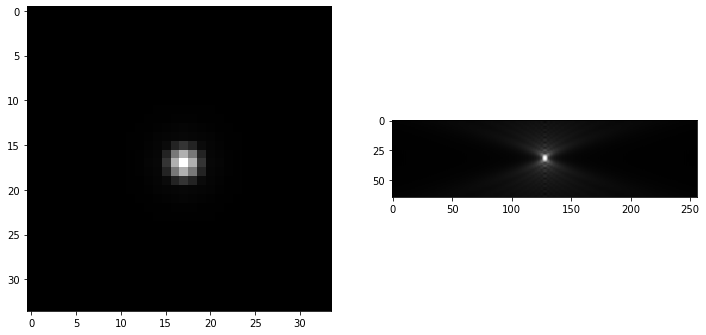

In [29]:
from scipy.ndimage.measurements import center_of_mass
fig, (a1, a2) = plt.subplots(1, 2, figsize=(12,6))
center = np.s_[truth_nx//2 - 17:truth_nx//2 + 17]
a1.imshow(_psf[truth_nz//2, center, center])
a2.imshow(_psf[:,truth_nx//2], norm=PowerNorm(gamma=0.4))
print(psf_nz, psf_nx)
print("psf shape: ", _psf.shape)
print(center_of_mass(_psf))

In [30]:
print("making illum")
nxyillum = 1
illum_shape = (truth_nz, nxyillum, nxyillum)
illum = structillum_3d_tex(
    illum_shape,
    angles,
    nphases,
    linespacing=linespacing,
    dx=truth_dx,
    dz=truth_dz,
    defocus=gratingDefocus,
    NA=NA,
    nimm=nimm,
    wvl=exwave,
)[0]
illum = illum[:, :, nxyillum // 2, nxyillum // 2, np.newaxis, np.newaxis].get()

making illum
p: 0, a: 0
p: 1, a: 0
p: 2, a: 0
p: 3, a: 0
p: 4, a: 0


In [31]:
out = illum * _psf[np.newaxis,:,:,:]
out = np.transpose(out, (1, 0, 2, 3)).reshape((-1, truth_nx, truth_nx))

In [32]:
final = downscale_local_mean(out, (1, upscale_xy, upscale_xy))
print(final.shape)
psffile = "/Users/talley/Desktop/ss/py_psf.dv"
mrc.imwrite(
    psffile,
    final.astype(np.float32),
    metadata={
        "dxy": out_dx,
        "dz": out_dz,
        "wave0": 1000 * emwave,
        "LensNum": 10612,
    }
)

(325, 256, 256)


makeotf /Users/talley/Desktop/ss/py_psf.dv /Users/talley/Desktop/ss/py_psf_otf.dv -angle 0 -ls 0.2035 -na 1.4058 -nimm 1.515 -fixorigin 3 20 -leavekz 8 10 2


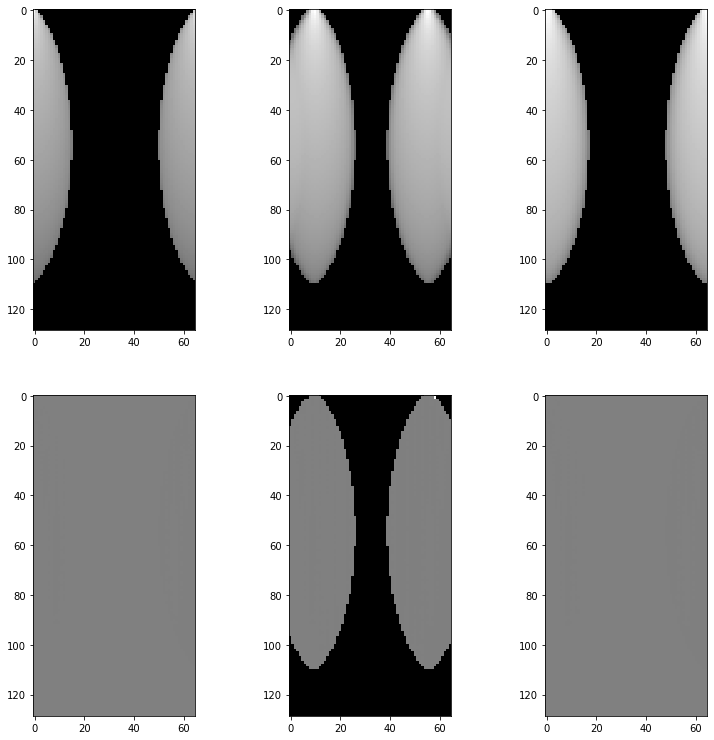

In [35]:
otffile = psffile.replace(".dv", "_otf.dv")
cmd = (f'makeotf {psffile} {otffile} -angle {angles[0]} -ls {linespacing}'
       f' -na {NA*0.99} -nimm {nimm} -fixorigin 3 20 -leavekz 8 10 2')
print(cmd)
subprocess.check_call(cmd.split())
im = mrc.bindFile(otffile)
fig, axs = plt.subplots(2, 3, figsize=(13,13))
axs[0, 0].imshow(np.abs(im[0]), norm=PowerNorm(gamma=0.1))
axs[0, 1].imshow(np.abs(im[1]), norm=PowerNorm(gamma=0.1))
axs[0, 2].imshow(np.abs(im[2]), norm=PowerNorm(gamma=0.1))
axs[1, 0].imshow(np.angle(im[0]), vmin=-1, vmax=1)
axs[1, 1].imshow(np.angle(im[1]), vmin=-1, vmax=1)
_ = axs[1, 2].imshow(np.angle(im[2]), vmin=-1, vmax=1)